# TARGETED VOLATILITY

In [12]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import itable
import ffn
import talib
import numpy as np
from cvxopt import matrix, solvers, spdiag

%matplotlib inline

def side_by_side(*objs, **kwds):
    from pandas.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    
# dummy logger
class Log() :
    pass
    def info (self, s) :
        print ('{} INFO : {}'.format(datetime.today().utcnow().replace(tzinfo=pytz.utc),s))
        pass
    def debug (self, s) :
        print ('{} DEBUG : {}'.format(datetime.today().utcnow().replace(tzinfo=pytz.utc)))
        pass
    def warn (self, s) :
        print ('{} WARNING : {}'.format(datetime.today().utcnow().replace(tzinfo=pytz.utc)))
        pass
        
log = Log()

In [7]:
import ffn

from fintools.Parameters import Parameters
from fintools.set_start_end import set_start_end
from fintools.get_yahoo_prices import get_yahoo_prices
from fintools.compute_weights_RS_DM import compute_weights_RS_DM
from fintools.endpoints import endpoints
from fintools.backtest import backtest
from fintools.monthly_return_table import monthly_return_table
from fintools.show_return_table import show_return_table
from fintools.portfolio_helper_functions import *

%matplotlib inline


In [28]:
# Portfolio Helper Functions

    # Functions:
    #    1. compute_efficient_portfolio        compute minimum variance portfolio
    #                                            subject to target return
    #    2. compute_global_min_portfolio       compute global minimum variance portfolio
    #    3. compute_tangency_portfolio         compute tangency portfolio
    #    4. compute_efficient_frontier         compute Markowitz bullet
    #    5. compute_portfolio_mu               compute portfolio expected return
    #    6. compute_portfolio_sigma            compute portfolio standard deviation
    #    7. compute_covariance_matrix          compute covariance matrix
    #    8. compute_expected_returns           compute expected returns vector
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def compute_covariance_matrix (prices):
    # calculates the cov matrix for the period defined by prices
    returns = np.log(1 + prices.pct_change())[1:]
    excess_returns_matrix = returns - returns.mean()
    return 1. / len(returns) * (excess_returns_matrix.T).dot(excess_returns_matrix)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def compute_expected_returns (prices):
    mu_vec =  np.log(1+prices.pct_change(1))[1:].mean()
    return mu_vec
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def compute_portfolio_mu (mu_vec, weights_vec):
    if len(mu_vec) != len(weights_vec) :
        raise RuntimeError ('mu_vec and weights_vec must have same length')
    return mu_vec.T.dot(weights_vec)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def compute_portfolio_sigma (sigma_mat, weights_vec) :

    if len(sigma_mat) != len(sigma_mat.columns) :
        raise RuntimeError ('sigma_mat must be square\nlen(sigma_mat) = {}\nlen(sigma_mat.columns) ={}'.
                            format(len(sigma_mat), len(sigma_mat.columns)))
    return np.sqrt(weights_vec.T.dot(sigma_mat).dot(weights_vec))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def compute_efficient_portfolio (mu_vec, sigma_mat, target_return, shorts=True) :

    # compute minimum variance portfolio subject to target return
    #
    # inputs:
    # mu_vec                  N x 1 DataFrame expected returns
    #                         with index = asset names
    # sigma_mat               N x N DataFrame covariance matrix of returns
    #                         with index = columns = asset names
    # target_return           scalar, target expected return
    # shorts                  logical, allow shorts is TRUE
    #
    # output is portfolio object with the following elements
    #
    # mu_p                   portfolio expected return
    # sig_p                  portfolio standard deviation
    # weights                N x 1 DataFrame vector of portfolio weights
    #                        with index = asset names

    # check for valid inputs
    #

    if len(mu_vec) != len(sigma_mat) :
        print ("dimensions of mu_vec and sigma_mat do not match")
        raise
    if np.matrix([sigma_mat.ix[i][i] for i in range(len(sigma_mat))]).any() <= 0 :
        print ('Covariance matrix not positive definite')
        raise

    #
    # compute efficient portfolio
    #

    solvers.options['show_progress'] = False
    P = 2 * matrix(sigma_mat.values)
    q = matrix(0., (len(sigma_mat), 1))
    G = spdiag([-1. for i in range(len(sigma_mat))])
    A = matrix(1., (1, len(sigma_mat)))
    A = matrix([A, matrix(mu_vec.T.values).T], (2,len(sigma_mat)))
    b = matrix([1.0, target_return], (2,1))

    if shorts == True :          
        h = matrix (1., (len(sigma_mat), 1))

    else :
        h = matrix (0., (len(sigma_mat), 1))

    # weights_vec = pd.DataFrame(np.array(solvers.qp(P, q, G, h, A, b)['x']),\
    #                                     sigma_mat.columns)
    weights_vec = pd.Series(list(solvers.qp(P, q, G, h, A, b)['x']), index=sigma_mat.columns)

    #
    # compute portfolio expected returns and variance
    #
    # print ('*** Debug ***\n_compute_efficient_portfolio:\nmu_vec:\n', self.mu_vec, '\nsigma_mat:\n',
    #        self.sigma_mat, '\nweights:\n', self.weights_vec )   
    weights_vec.index = mu_vec.index
    mu_p = compute_portfolio_mu(mu_vec, weights_vec)
    sigma_p = compute_portfolio_sigma (sigma_mat, weights_vec)

    return weights_vec, mu_p, sigma_p    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def compute_global_min_portfolio (mu_vec, sigma_mat, shorts=True) :

    solvers.options['show_progress'] = False
    P = 2 * matrix(sigma_mat.values)
    q = matrix(0., (len(sigma_mat), 1))
    G = spdiag([-1. for i in range(len(sigma_mat))])
    A = matrix(1., (1, len(sigma_mat)))
    b = matrix(1.0)

    if shorts == True :
        h = matrix (1., (len(sigma_mat), 1))
    else :
        h = matrix (0., (len(sigma_mat), 1))

    #print ('\nP\n\n{}\n\nq\n\n{}\n\nG\n\n{}\n\nh\n\n{}\n\nA\n\n{}\n\nb\n\n{}\n\n'.format(P,q,G,h,A,b))
    # weights_vec = pd.DataFrame(np.array(solvers.qp(P, q, G, h, A, b)['x']),\
    #                                     index=sigma_mat.columns)
    weights_vec = pd.Series(list(solvers.qp(P, q, G, h, A, b)['x']), index=sigma_mat.columns)

    #
    # compute portfolio expected returns and variance
    #
    # print ('*** Debug ***\n_Global Min Portfolio:\nmu_vec:\n', mu_vec, '\nsigma_mat:\n', 
    #        sigma_mat, '\nweights:\n', weights_vec)

    mu_p = compute_portfolio_mu(mu_vec, weights_vec)
    sigma_p = compute_portfolio_sigma (sigma_mat, weights_vec)

    return weights_vec, mu_p, sigma_p

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def compute_efficient_frontier(mu_vec, sigma_mat, risk_free=0, points=100, shorts=True):

    efficient_frontier = pd.DataFrame(index=range(points), dtype=object, columns=['mu_p', 'sig_p', 'sr_p', 'wts_p'])

    gmin_wts, gmin_mu, gmin_sigma = compute_global_min_portfolio(mu_vec, sigma_mat, shorts=shorts)

    xmax = mu_vec.max()
    if shorts == True:
        xmax = 2 * mu_vec.max()
    for i, mu in enumerate(np.linspace(gmin_mu, xmax, points)):
        w_vec, portfolio_mu, portfolio_sigma = compute_efficient_portfolio(mu_vec, sigma_mat, mu, shorts=shorts)
        efficient_frontier.ix[i]['mu_p'] = w_vec.dot(mu_vec)
        efficient_frontier.ix[i]['sig_p'] = np.sqrt(w_vec.T.dot(sigma_mat.dot(w_vec)))
        efficient_frontier.ix[i]['sr_p'] = (efficient_frontier.ix[i]['mu_p'] - risk_free)  / efficient_frontier.ix[i]['sig_p']
        efficient_frontier.ix[i]['wts_p'] = w_vec

    return efficient_frontier
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def compute_tangency_portfolio(mu_vec, sigma_mat, risk_free=0, shorts=True):

    efficient_frontier = self._compute_efficient_frontier(mu_vec, sigma_mat, risk_free, shorts=shorts)
    index = efficient_frontier.index[efficient_frontier['sr_p']==efficient_frontier['sr_p'].max()]

    wts = efficient_frontier['wts_p'][index].values[0]
    mu_p = efficient_frontier['mu_p'][index].values[0]
    sigma_p = efficient_frontier['sig_p'][index].values[0]
    sharpe_p = efficient_frontier['sr_p'][index].values[0]

    return wts, mu_p, sigma_p, sharpe_p
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def compute_target_risk_portfolio(mu_vec, sigma_mat, target_risk, risk_free=0, shorts=True):

    efficient_frontier = compute_efficient_frontier(mu_vec, sigma_mat, risk_free, shorts=shorts)
    if efficient_frontier['sig_p'].max() <= target_risk :
        log.warn ('TARGET_RISK {} > EFFICIENT FRONTIER MAXIMUM {}; SETTING IT TO MAXIMUM'.
                 format(target_risk, efficient_frontier['sig_p'].max()))
        index = len(efficient_frontier) - 1
    elif efficient_frontier['sig_p'].min() >= target_risk :
        log.warn ('TARGET RISK {} < GLOBAL MINIMUM {}; SETTING IT TO GLOBAL MINIMUM'.
                 format(target_risk, efficient_frontier['sig_p'].max()))
        index = 1
    else :
        index = efficient_frontier.index[efficient_frontier['sig_p'] >= target_risk][0]

    wts = efficient_frontier['wts_p'][index]
    mu_p = efficient_frontier['mu_p'][index]
    sigma_p = efficient_frontier['sig_p'][index]
    sharpe_p = efficient_frontier['sr_p'][index]

    return wts, mu_p, sigma_p, sharpe_p

In [3]:
def monthly_return_table (daily_prices) :
    #monthly_returns = daily_prices.resample('M').last().pct_change()
    monthly_returns = daily_prices.resample('M', how='last').pct_change()
    df = pd.DataFrame(monthly_returns.values, columns=['Data'])
    df['Month'] = monthly_returns.index.month
    df['Year']= monthly_returns.index.year
    table = df.pivot_table(index='Year', columns='Month').fillna(0).round(4) * 100
    #annual_returns = daily_prices.resample('12M').last().pct_change()[1:].values.round(4) * 100
    annual_returns = daily_prices.resample('12M', how='last').pct_change()[1:].values.round(4) * 100
    if len(table) > len(annual_returns) :
        table = table[1:]
    table['Annual Returns'] = annual_returns
    return table

In [4]:
def endpoints(start=None, end=None, period='m', trading_days=None) :
    
    if trading_days is not None:
        dates = trading_days
# the following 2 lines cause python 3.4.2 to crash, so removed them
#    elif start is not None and end is not None:
#        dates = tradingcalendar.get_trading_days(start, end)
    else:
        print ('\n** ERROR : must either provide pandas series (or df) of trading days \n')
        print ('           or a start and end date\n')
    
    if isinstance(period, int) :
        dates = [dates[i] for i in range(0, len(dates), period)]
    else :    
        if period == 'm' : months = 1
        elif period == 'q' : months = 3
        elif period == 'b' : months = 6
        elif period == 'y' : months = 12           
            
        e_dates = [dates[i - 1] for i in range(1,len(dates))\
                          if dates[i].month > dates[i-1].month\
                          or dates[i].year > dates[i-1].year ]+ list([dates[-1]])
        dates = [e_dates[i] for i in range(0,len(e_dates),months)]
    
    return dates

In [5]:
# THIS ONE MATCHES PV
# SEE PV backtest :https://goo.gl/lBR4K9
# AND spreadsheet : https://goo.gl/8KGp58
# and Quantopian backtest : https://goo.gl/xytT5L

def backtest(prices, weights, capital, offset=1, commission=0.) :
    rebalance_dates = weights.index
    buy_dates = [prices.index[d + offset] for d in range(len(prices.index)-1) if prices.index[d] in rebalance_dates ]
    print ('FIRST BUY DATE = {}\n'.format(buy_dates[0]))
    p_holdings = pd.DataFrame(0, index=prices.index, columns=prices.columns)
    cash = 0.
    for i, date in enumerate(prices.index):
        if date in rebalance_dates :
#             print ('--------------------------------------------------------------------') 
            new_weights = weights.loc[date]
            p_holdings.iloc [i] = p_holdings.iloc [i - 1]
        if date in buy_dates :           
            if date == buy_dates[0] :
                p_holdings.loc[date] = (capital * weights.iloc[0] / prices.loc[date])
#                 print ('INIT', cash, p_holdings.iloc[i-1],prices.loc[date], new_weights)
            else :
                portfolio_value = cash + (p_holdings.iloc[i - 1] * prices.loc[date]).sum() * new_weights
                p_holdings.iloc[i] = (portfolio_value / prices.loc[date]).fillna(0)
#                 print ('{} BUY \n{}\n{}\n{}\n{}\n{}\nHOLDINGS\n{}\n'.format(date,cash,portfolio_value,p_holdings.iloc[i-1],
#                                                                     prices.loc[date],new_weights,p_holdings.iloc[i]))
                cash = (portfolio_value - p_holdings.iloc[i] * prices.loc[date]).sum()
#                 print ('{}\nPORTFOLIO VALUE\n{}\nCASH = {}'.format(date, portfolio_value,cash))
        else :
            p_holdings.iloc [i] = p_holdings.iloc [i - 1]
            #print ('{} HOLDINGS UNCHANGED'.format(date))

    p_value = (p_holdings * prices).sum(1)[p_holdings.index>=buy_dates[0]]
#     print(p_holdings, )
    p_weights = p_holdings.mul(prices).div(p_holdings.mul(prices).sum(axis=1), axis=0).fillna(0)
    
    return p_value, p_holdings, p_weights

# VTARGET1

INCEPTION DATES:

          inception
Symbols            
FDFAX    1985-07-29
VFIIX    1984-12-31
VGHCX    1984-12-31
FIRST BUY DATE = 1985-09-30 00:00:00



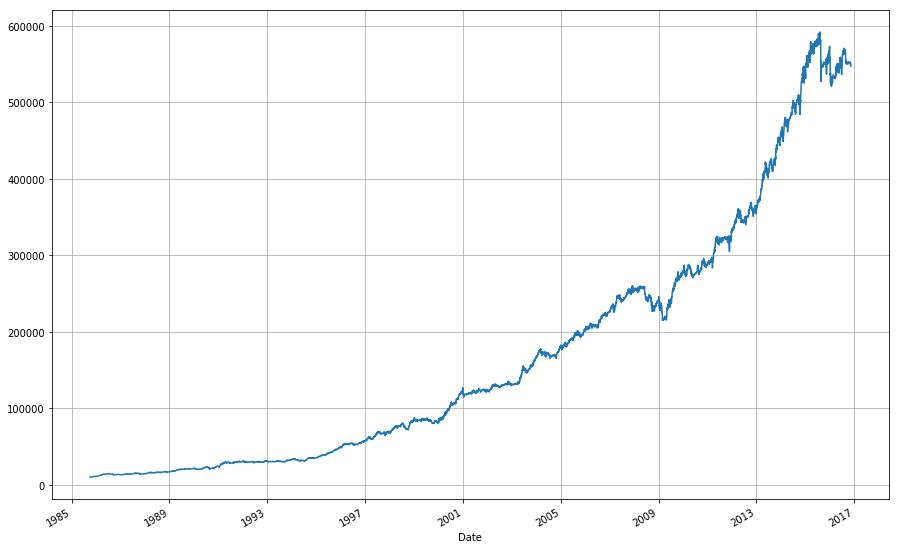

In [8]:
symbols =['VGHCX', 'FDFAX']
cash_proxy = 'VFIIX'

tickers = list(set(symbols + [cash_proxy]))

start_date='1985-01-01'
end_date='2016-11-10'

# Define which online source one should use
data_source = 'yahoo'

## User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)
data = panel_data['Adj Close'].sort_index(ascending=True)

inception_dates = pd.DataFrame([data[ticker].first_valid_index().date() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])
                               
print ('INCEPTION DATES:\n\n{}'.format(inception_dates))

prices = data.copy().dropna()

end_points = endpoints(period='M', trading_days=prices.index)
prices_m = prices.loc[end_points]

risk_lookback = 3
allocations = [0.6, 0.4]

# elligibility rule
# SMA = prices_m.rolling(risk_lookback).mean().dropna()
SMA = prices_m.rolling(risk_lookback).mean().dropna()
rebalance_dates = SMA.index
rule = prices_m.reindex(rebalance_dates)[symbols] > SMA[symbols]

# fixed weight allocation
weights = allocations * rule

# downside protection
weights[cash_proxy] = 1 - weights[symbols].sum(axis=1)

# backtest
p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [9]:
mu_vec = compute_expected_returns(prices_m)
mu_vec

Symbols
FDFAX    0.009976
VFIIX    0.005444
VGHCX    0.011930
dtype: float64

In [10]:
sigma_mat = compute_covariance_matrix(prices_m)
sigma_mat

Symbols,FDFAX,VFIIX,VGHCX
Symbols,,,
FDFAX,0.001507,0.000070,0.001218
VFIIX,0.000070,0.000104,0.000051
VGHCX,0.001218,0.000051,0.001744


In [11]:
compute_target_risk_portfolio(mu_vec, sigma_mat, target_risk=0.01, risk_free=0, shorts=False)

TARGET RISK 0.01 < GLOBAL MINIMUM 0.041760938075843176; SETTING IT TO GLOBAL MINIMUM


(Symbols
 FDFAX    0.002311
 VFIIX    0.959209
 VGHCX    0.038481
 dtype: float64,
 0.005704051086311446,
 0.010128918727484863,
 0.5631451134891111)